## seq2seq practice
### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [12]:
start_token = "<"
end_token = ">"
def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line + end_token for line in names ]
        return names

In [13]:
try:
    names = read_names('./names')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')

In [14]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
<Abagael>
<Claresta>
<Glory>
<Liliane>
<Prissie>
<Geeta>
<Giovanne>
<Piggy>


max length = 17


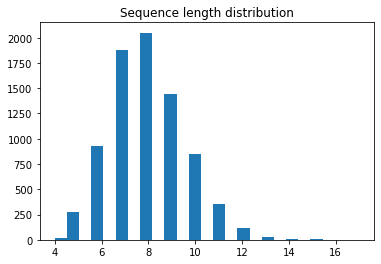

In [15]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [16]:
tokens = list(set(' '.join(names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  57


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [17]:
token_to_id = {char: idx for idx, char in enumerate(tokens)}
token_to_id['\t'] = len(token_to_id)
tokens.append('\t')
num_tokens += 1

In [18]:
tokens

['t',
 'C',
 'F',
 'c',
 'a',
 'j',
 'b',
 'h',
 'Z',
 'Q',
 ' ',
 'n',
 'i',
 'D',
 'e',
 "'",
 'I',
 'g',
 'A',
 'v',
 'K',
 'B',
 'N',
 'P',
 '-',
 'R',
 'm',
 'p',
 'V',
 'r',
 'H',
 '<',
 'E',
 'L',
 'k',
 'W',
 'u',
 's',
 'S',
 'U',
 'Y',
 'J',
 '>',
 'z',
 'o',
 'y',
 'T',
 'd',
 'w',
 'M',
 'X',
 'G',
 'f',
 'q',
 'x',
 'l',
 'O',
 '\t']

In [19]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [20]:
def to_matrix(names, max_len=None, pad=token_to_id['\t'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names)) + 1
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        names_ix[i, len(line_ix)] = 0
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [21]:
names[:2]

['<Abagael>', '<Abagail>']

In [22]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

<Abagael>
<Glory>
<Prissie>
<Giovanne>
[[31 18  6  4 17  4 14 55 42  0 57]
 [31 51 55 44 29 45 42  0 57 57 57]
 [31 23 29 12 37 37 12 14 42  0 57]
 [31 51 12 44 19  4 11 11 14 42  0]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [23]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [24]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(token_to_id), embedding_size=24, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [25]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [26]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [27]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [165]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

In [166]:
loss.backward()

In [167]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [28]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss(ignore_index=token_to_id['\t'])
opt = torch.optim.Adam(char_rnn.parameters())
history = []

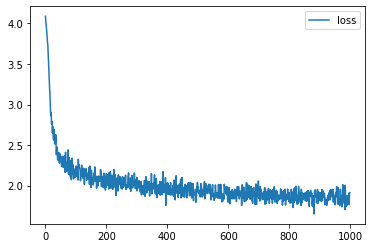

In [29]:
MAX_LENGTH = 20

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [185]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        if next_ix == 0:
            continue
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [171]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase='<'))

<Reobbrellin>
<Nagnella>
<Brodere>hy>
<Kila>
<Telis>
<Anegarend>
<Dabylie>
<Ilaan>
<Sepina>r
<Rafky>


### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [221]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(token_to_id), emb_size=32, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=token_to_id['\t'])
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [222]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []
criterion = nn.NLLLoss(ignore_index=token_to_id['\t'])

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 2), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

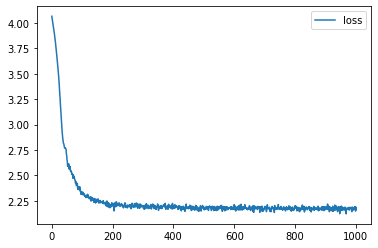

In [225]:
MAX_LENGTH = 20
model.train()
for i in range(1000):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 512), max_len=MAX_LENGTH)
    batch_ix = torch.LongTensor(batch_ix)
    batch_ix = batch_ix.transpose(1,0)

    logp_seq = model(batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [249]:
batch_ix = to_matrix(sample(names, 3), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)
batch_ix = batch_ix.transpose(1,0)

logp_seq = model(batch_ix)

# compute loss
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

In [284]:
print(predictions_logp.shape)
print(actual_next_tokens.shape)

torch.Size([20, 2, 58])
torch.Size([20, 2])


In [292]:
p = torch.tensor([[[0.1, 0.4, 0.25, 0.05, 0.2],
                 [0.1, 0.15, 0.5, 0.05, 0.2],
                 [0.3, 0.05, 0.05, 0.4, 0.2]],
                 [[0.2, 0.2, 0.35, 0.05, 0.1],
                 [0.1, 0.5, 0.15, 0.05, 0.2],
                 [0.3, 0.05, 0.4, 0.05, 0.2]]
                 ])
log_p = torch.log(p)
targ = torch.tensor([[1, 2, 3],[2, 1, 2]])
print(criterion(log_p.contiguous().view(-1, 5), targ.contiguous().view(-1)))

tensor(0.8642)


In [287]:
print(log_p.shape)
print(targ.shape)

torch.Size([2, 3, 5])
torch.Size([2, 3])


In [187]:
def generate_sample_lstm(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        model(x_sequence[:, :, i])
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next = model(x_sequence[:, -1])
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
#     return x_sequence
    name_id = []
    for ix in x_sequence.data.numpy()[0][0]:
        if tokens[ix] == '\t':
            break
        name_id.append(tokens[ix])
        
    return (''.join(name_id), x_sequence.data.numpy()[0][0])

In [226]:
model.eval()
for _ in range(10):
    name, nam_id = generate_sample_lstm(model, seed_phrase='<D')
    print(f"{name} <- {nam_id}")

<DM<<<SQ<o<<D<BKV<yU <- [31 13 49 31 31 31 38  9 31 44 31 31 13 31 21 20 28 31 45 39]
<D<LG<PM<tCMTAsB<T<< <- [31 13 31 33 51 31 23 49 31  0  1 49 46 18 37 21 31 46 31 31]
<Dn<NLBb<<<O<<<<><e< <- [31 13 11 31 22 33 21  6 31 31 31 56 31 31 31 31 42 31 14 31]
<DE<<<<HE<RCq<<<L<<< <- [31 13 32 31 31 31 31 30 32 31 25  1 53 31 31 31 33 31 31 31]
<DA<<<<s<<C<>C><RV<< <- [31 13 18 31 31 31 31 37 31 31  1 31 42  1 42 31 25 28 31 31]
<Dt<<<sZO<<Q<<<<<P>V <- [31 13  0 31 31 31 37  8 56 31 31  9 31 31 31 31 31 23 42 28]
<Di<<J<T<<<<ML<s<<J< <- [31 13 12 31 31 41 31 46 31 31 31 31 49 33 31 37 31 31 41 31]
<D<<<<WCN<<<<<odA<<< <- [31 13 31 31 31 31 35  1 22 31 31 31 31 31 44 47 18 31 31 31]
<D<Y><R<<<k<<<<ZEa<< <- [31 13 31 40 42 31 25 31 31 31 34 31 31 31 31  8 32  4 31 31]
<D<<D<G<<<-<<z<n<<<G <- [31 13 31 31 13 31 51 31 31 31 24 31 31 43 31 11 31 31 31 51]


In [236]:
logp_next = model(torch.tensor([[25]]))
p_next = F.softmax(logp_next, dim=-1).data.numpy()[0][0]

In [237]:
p_next

array([0.01319203, 0.03462558, 0.02577493, 0.00779162, 0.01351129,
       0.00798244, 0.00859434, 0.00907269, 0.01948843, 0.01505767,
       0.00793143, 0.00921336, 0.01094284, 0.03240525, 0.01128962,
       0.00917009, 0.01990568, 0.00918885, 0.03857226, 0.00831781,
       0.02466387, 0.02836506, 0.02476652, 0.02280442, 0.00758291,
       0.02660838, 0.00873752, 0.00773033, 0.02606745, 0.01510623,
       0.02680822, 0.02524382, 0.03119349, 0.02891901, 0.00889857,
       0.02414249, 0.01057359, 0.0090313 , 0.03637827, 0.01514306,
       0.01687665, 0.03070821, 0.01468451, 0.00958661, 0.0106571 ,
       0.0095552 , 0.02902654, 0.01055788, 0.00855706, 0.0334233 ,
       0.01336667, 0.02705621, 0.00828909, 0.00919621, 0.00829407,
       0.00971359, 0.021706  , 0.00795245], dtype=float32)

### To sum up:
- PyTorch is convenient both for prototyping and production
- There are a lot of pre-implemented methods/layers/activations out of the box
- It's much easier (*really easier*) to use PyTorch than TensorFlow on entry level. 
- Neural networks are not *black boxes*, they are pretty nice and easy to use (almost always).

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

In [219]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [220]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [221]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [222]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [223]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)